# Single Image VLM Testing

This notebook allows you to:
1. Select a specific Safaitic inscription
2. Test different prompts on individual images
3. Compare VLM output with ground truth
4. Evaluate the results

Perfect for exploring VLM capabilities and refining prompts.

## Setup

In [1]:
import sys
from pathlib import Path
import json

# Add src to path
project_root = Path().absolute().parent
sys.path.insert(0, str(project_root))

from src import (
    load_metadata,
    get_inscription_data,
    list_available_inscriptions,
    LlamaVision,
    SafaiticPrompts,
    InscriptionEvaluator
)

import matplotlib.pyplot as plt
from IPython.display import display, HTML, Markdown
import pandas as pd

print("✓ Setup complete")

✓ Setup complete


In [2]:
# Initialize components
llama = LlamaVision(model_name="llama3.2-vision")
prompts = SafaiticPrompts()
evaluator = InscriptionEvaluator()

# Verify model is available
if not llama.check_availability():
    print("⚠ Warning: Llama 3.2 Vision not available. Analysis will not work.")
else:
    print("✓ Model ready")

✓ llama3.2-vision is available
✓ Model ready


In [3]:
# Load metadata
metadata_path = project_root / "metadata" / "BES15.csv"
data_dir = project_root / "data"
df = load_metadata(str(metadata_path))

Loaded 3753 records from /Users/shaigordin/Dropbox/Git-projects/safaitic-ocr/metadata/BES15.csv
Unique inscriptions: 1401


## Select an Inscription to Analyze

In [4]:
# List available inscriptions
available = list_available_inscriptions(df)
print(f"Available inscriptions: {len(available)}\n")
print("Sample IDs:", available[:20])

Available inscriptions: 1401

Sample IDs: ['BES15 1', 'BES15 10', 'BES15 100', 'BES15 1000', 'BES15 1001', 'BES15 1002', 'BES15 1003', 'BES15 1004', 'BES15 1005', 'BES15 1006', 'BES15 1007', 'BES15 1008', 'BES15 1009', 'BES15 101', 'BES15 1010', 'BES15 1011', 'BES15 1012', 'BES15 1013', 'BES15 1014', 'BES15 1015']


In [14]:
# Choose an inscription
INSCRIPTION_ID = "BES15 1"  # Change this to test different inscriptions

# Load inscription data
inscription = get_inscription_data(df, str(data_dir), INSCRIPTION_ID, load_images=True)

print(f"Loaded: {inscription.inscription_id}")
print(f"Images: {len(inscription.images) if inscription.images else 0}")
print(f"\nGround Truth Transliteration:\n{inscription.transliteration}")
print(f"\nGround Truth Translation:\n{inscription.translation}")

Loaded 15 images from BES15 1
Loaded: BES15 1
Images: 15

Ground Truth Transliteration:
l ṯfl bn frʾ bn frd w qbr bny -h b h- mẓr

Ground Truth Translation:
By Ṯfl son of Frʾ son of Frd and he buried his sons at the lookout point.


## Display Images

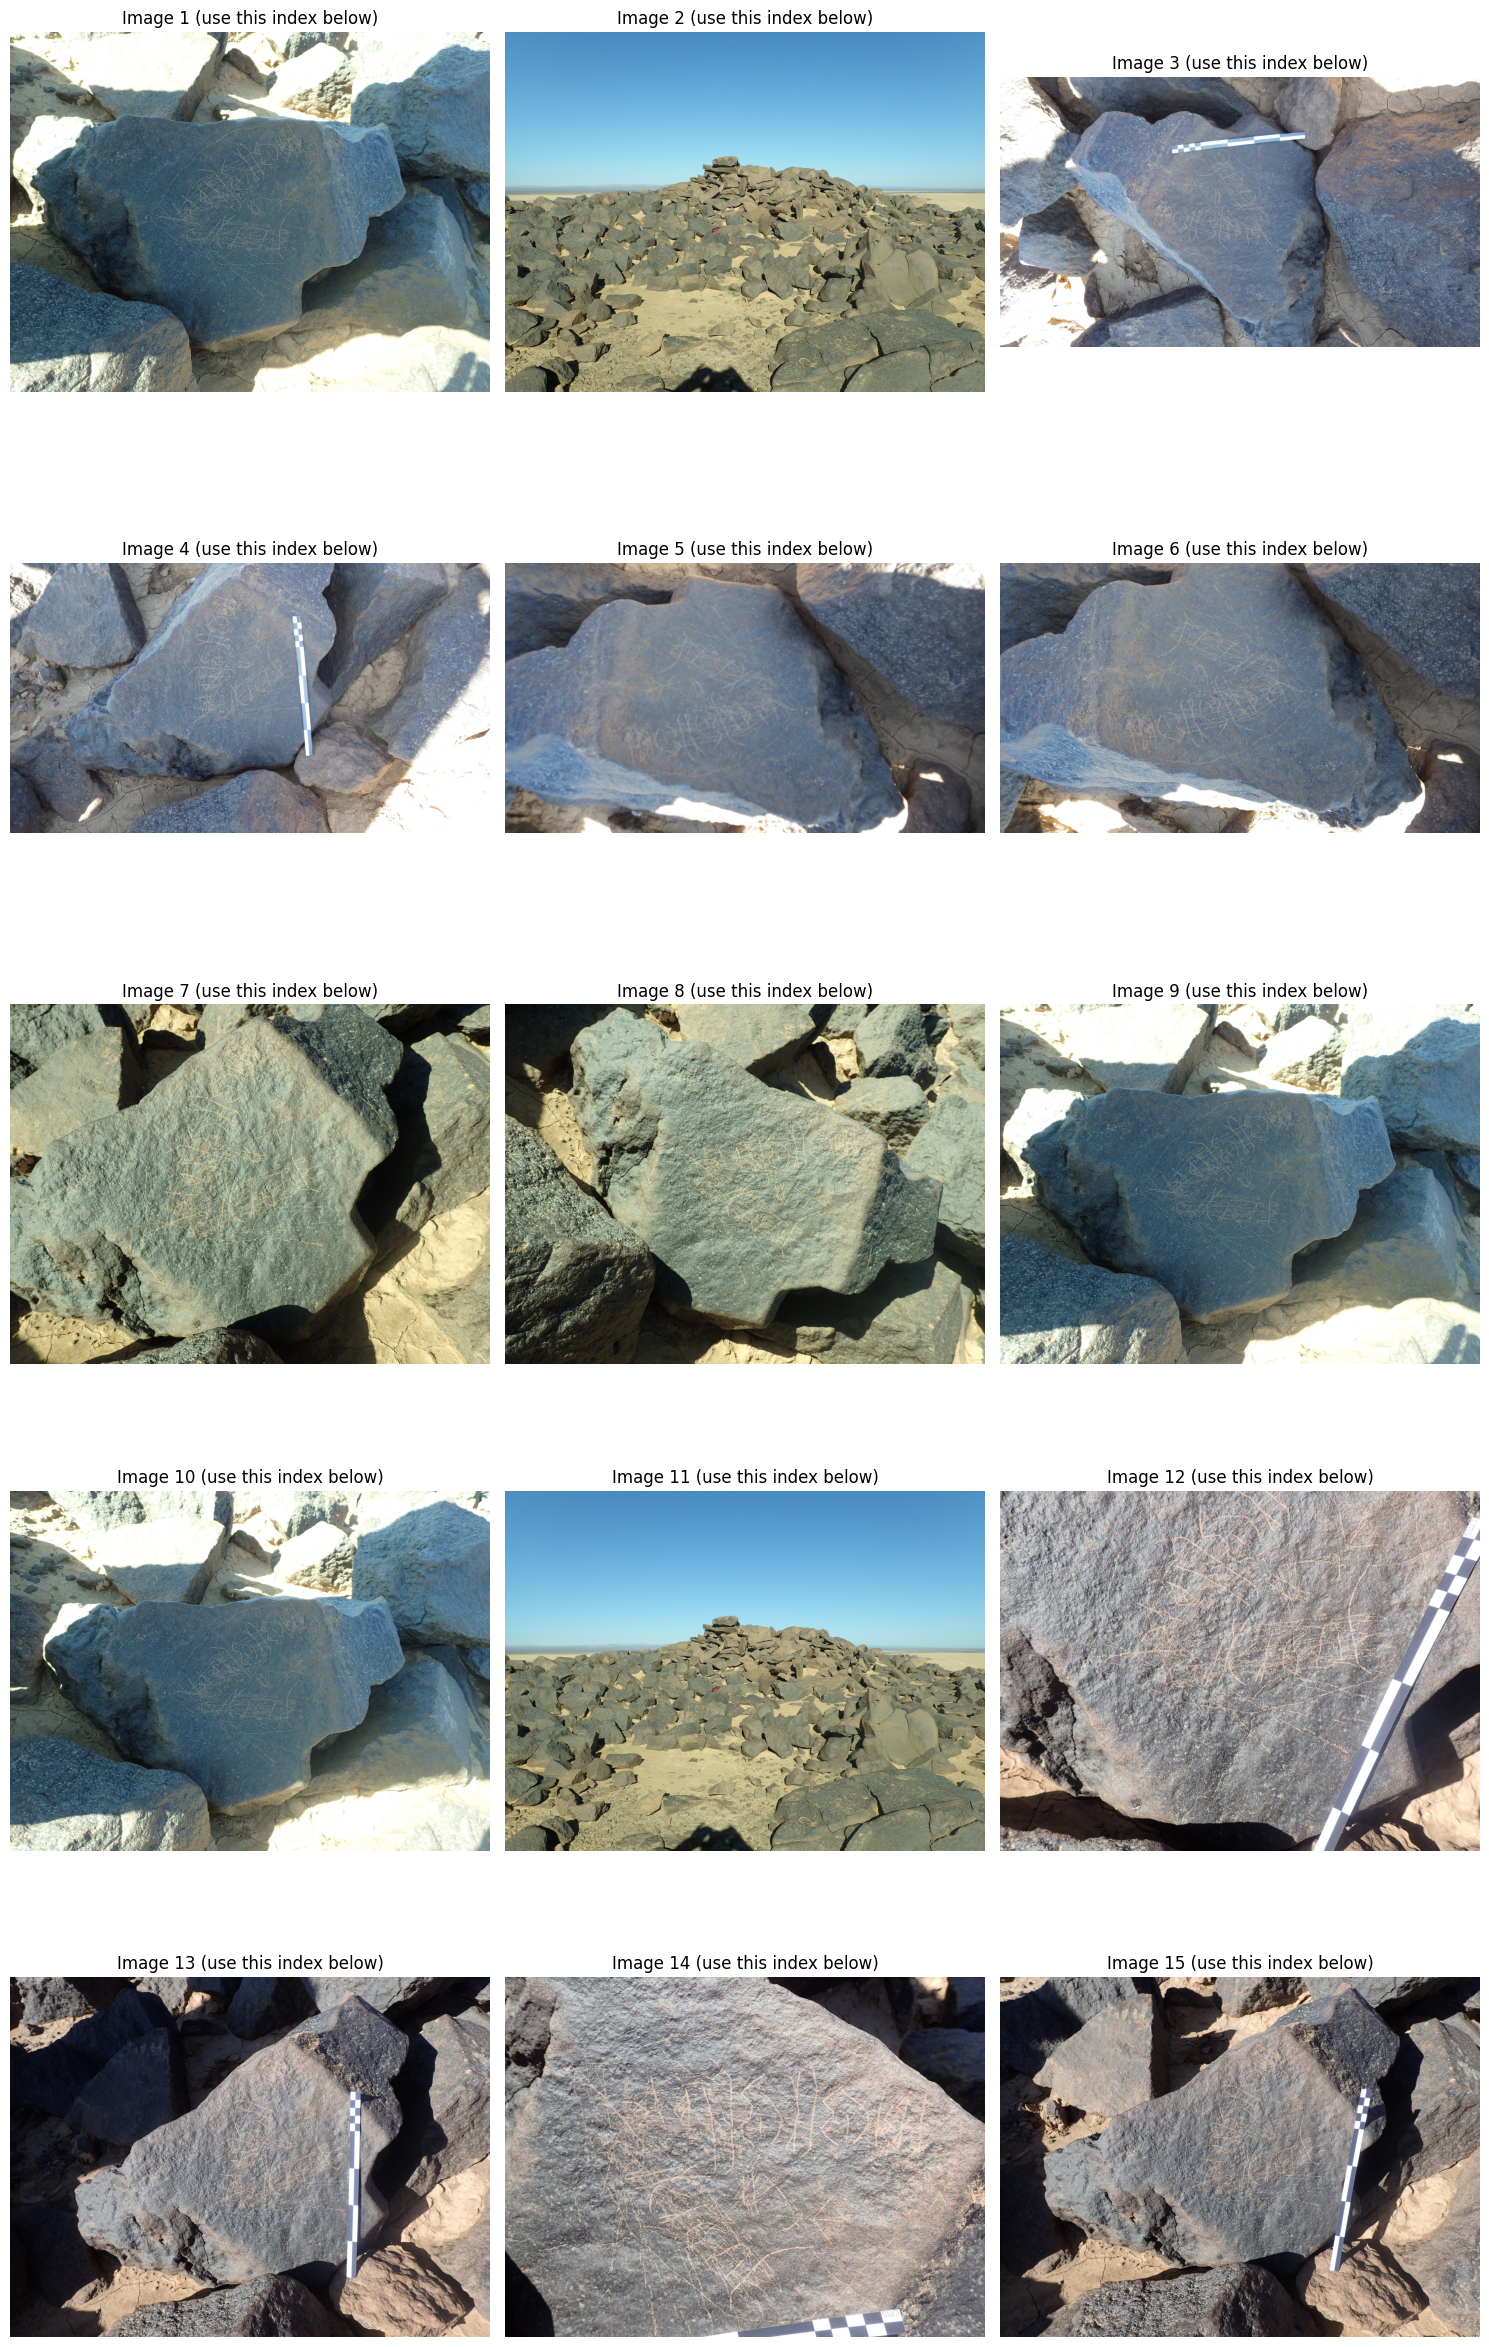

In [15]:
# Show all images for this inscription
if inscription.images:
    n_images = len(inscription.images)
    n_cols = min(3, n_images)
    n_rows = (n_images + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
    if n_images == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_rows > 1 else axes
    
    for idx, img in enumerate(inscription.images):
        axes[idx].imshow(img)
        axes[idx].set_title(f"Image {idx + 1} (use this index below)")
        axes[idx].axis('off')
    
    # Hide empty subplots
    for idx in range(n_images, n_rows * n_cols):
        axes[idx].axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠ No images loaded for this inscription")

## Test Different Prompts

Selected image 1 for analysis


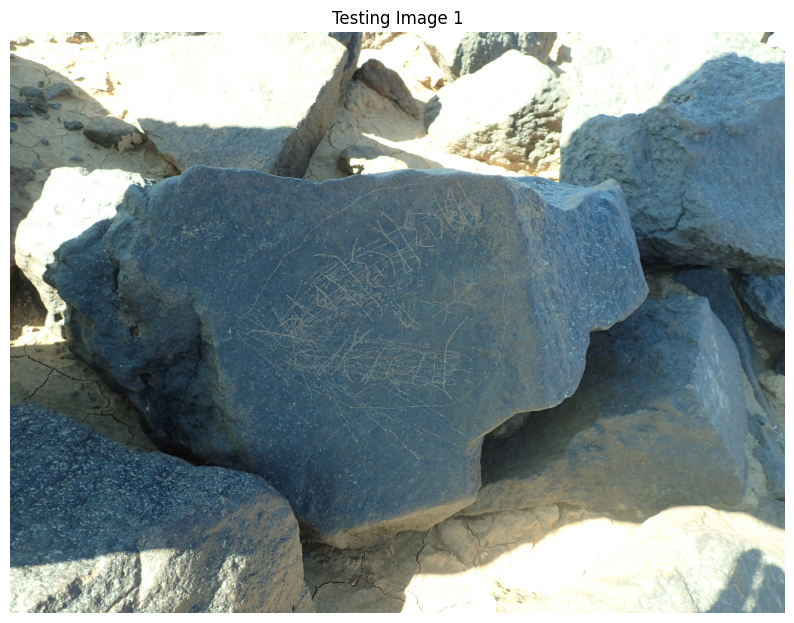

In [16]:
# Select which image to analyze (0-indexed)
IMAGE_INDEX = 0

if inscription.images and IMAGE_INDEX < len(inscription.images):
    test_image = inscription.images[IMAGE_INDEX]
    print(f"Selected image {IMAGE_INDEX + 1} for analysis")
    
    # Display selected image
    plt.figure(figsize=(10, 8))
    plt.imshow(test_image)
    plt.title(f"Testing Image {IMAGE_INDEX + 1}")
    plt.axis('off')
    plt.show()
else:
    print("⚠ Invalid image index or no images available")
    test_image = None

### Test 1: Basic Script Identification

In [17]:
if test_image:
    prompt = prompts.script_identification()
    print("Prompt:")
    print(prompt)
    print("\n" + "="*60 + "\n")
    
    result = llama.analyze_image(test_image, prompt, temperature=0.1)
    
    if result['success']:
        print("VLM Response:")
        print(result['response'])
        print("\n" + "="*60 + "\n")
        
        # Evaluate script identification
        identification = evaluator.check_script_identification(result['response'])
        print("Evaluation:")
        print(f"  Correctly identified as Safaitic: {identification['correctly_identified']}")
        print(f"  Confidence score: {identification['confidence']:.2f}")
        print(f"  Mentions right-to-left: {identification['mentions_rtl']}")
        print(f"  Mentions inscription/carved: {identification['mentions_inscription']}")
    else:
        print(f"Error: {result.get('error')}")

Prompt:
Analyze this image carefully. 

1. Is there any text or inscription visible?
2. If yes, what writing system or script does it appear to be?
3. Describe the characteristics of the characters you see.
4. Is the text carved, painted, or written in some other way?

Be specific about what you observe.


VLM Response:
The image shows a large, dark gray rock with several scratches on its surface. The scratches appear to be random and do not form any recognizable pattern or text. They are likely the result of natural weathering or erosion rather than intentional carving or inscription.

Therefore, the answer to the questions is:

1. No, there is no text or inscription visible.
2. There is no writing system or script visible.
3. The characters are not visible, as there are no characters present.
4. The text is not carved, painted, or written in any other way, as there is no text present.


Evaluation:
  Correctly identified as Safaitic: False
  Confidence score: 0.30
  Mentions right-to

### Test 2: Character Recognition

In [18]:
if test_image:
    prompt = prompts.character_recognition(provide_context=True)
    print("Prompt:")
    print(prompt)
    print("\n" + "="*60 + "\n")
    
    result = llama.analyze_image(test_image, prompt, temperature=0.1)
    
    if result['success']:
        print("VLM Response:")
        print(result['response'])
    else:
        print(f"Error: {result.get('error')}")

Prompt:
This is a Safaitic inscription (ancient North Arabian script, right-to-left, 28 consonantal letters).

List the characters you can identify in this inscription:
1. Individual letters or characters visible
2. Writing direction
3. Any unclear or damaged portions


Error: Request timed out after 180 seconds. Try increasing timeout or using a simpler prompt.


### Test 3: Transliteration Attempt

In [ ]:
if test_image:
    prompt = prompts.transliteration_attempt(include_primer=True)
    print("Prompt:")
    print(prompt)
    print("\n" + "="*60 + "\n")
    
    result = llama.analyze_image(test_image, prompt, temperature=0.1)
    
    if result['success']:
        print("VLM Response:")
        print(result['response'])
        print("\n" + "="*60 + "\n")
        
        # Evaluate against ground truth
        evaluation = evaluator.evaluate_inscription(
            inscription.transliteration,
            inscription.translation,
            result['response']
        )
        
        print("\nEvaluation Results:")
        print(f"  Overall Score: {evaluation['overall_score']:.3f}")
        print(f"  Character Similarity: {evaluation['character_metrics']['similarity_ratio']:.3f}")
        print(f"  Word Accuracy: {evaluation['word_metrics']['word_accuracy']:.3f}")
        print(f"  Semantic F1: {evaluation['semantic_metrics']['keyword_f1']:.3f}")
        
        print("\nGround Truth vs Prediction:")
        print(f"  Expected: {inscription.transliteration}")
        print(f"  Extracted: {evaluation['prediction']['extracted_transliteration']}")
    else:
        print(f"Error: {result.get('error')}")

### Test 4: Translation Attempt

In [ ]:
if test_image:
    prompt = prompts.translation_attempt()
    print("Prompt:")
    print(prompt)
    print("\n" + "="*60 + "\n")
    
    result = llama.analyze_image(test_image, prompt, temperature=0.1)
    
    if result['success']:
        print("VLM Response:")
        print(result['response'])
        print("\n" + "="*60 + "\n")
        
        # Compare with ground truth translation
        semantic_eval = evaluator.semantic_similarity(
            inscription.translation,
            result['response']
        )
        
        print("\nSemantic Evaluation:")
        print(f"  Text Similarity: {semantic_eval['text_similarity']:.3f}")
        print(f"  Keyword F1 Score: {semantic_eval['keyword_f1']:.3f}")
        print(f"\n  Expected keywords: {semantic_eval['ground_truth_keywords']}")
        print(f"  Predicted keywords: {semantic_eval['prediction_keywords']}")
        print(f"  Matching keywords: {semantic_eval['matching_keywords']}")
        
        print("\n  Ground Truth: {}".format(inscription.translation))
    else:
        print(f"Error: {result.get('error')}")

### Test 5: Condition Assessment

In [ ]:
if test_image:
    prompt = prompts.condition_assessment()
    print("Prompt:")
    print(prompt)
    print("\n" + "="*60 + "\n")
    
    result = llama.analyze_image(test_image, prompt, temperature=0.1)
    
    if result['success']:
        print("VLM Response:")
        print(result['response'])
    else:
        print(f"Error: {result.get('error')}")

## Multi-Image Analysis (Optional)

In [ ]:
# Test comparative analysis if multiple images available
if inscription.images and len(inscription.images) > 1:
    print(f"Analyzing {len(inscription.images)} images together...")
    
    prompt = prompts.comparative_analysis()
    
    # Use first 3 images to keep processing manageable
    test_images = inscription.images[:3]
    
    results = llama.analyze_multiple_images(
        test_images,
        prompt,
        temperature=0.1,
        combine_method="compare"
    )
    
    if results and results[0]['success']:
        print("\nComparative Analysis Result:")
        print(results[0]['response'])
    else:
        print("Error in multi-image analysis")
else:
    print("Only one image available, skipping multi-image analysis")

## Save Results (Optional)

In [ ]:
# Save test results to JSON file
output = {
    "inscription_id": inscription.inscription_id,
    "image_index": IMAGE_INDEX,
    "ground_truth": {
        "transliteration": inscription.transliteration,
        "translation": inscription.translation,
    },
    "tests": [
        # Add your test results here
    ]
}

# Uncomment to save:
# output_path = project_root / "results" / f"test_{inscription.inscription_id.replace(' ', '_')}.json"
# output_path.parent.mkdir(exist_ok=True)
# with open(output_path, 'w') as f:
#     json.dump(output, f, indent=2)
# print(f"Results saved to {output_path}")

## Experiment Further

Try:
- Different inscriptions (change `INSCRIPTION_ID`)
- Different images of the same inscription (change `IMAGE_INDEX`)
- Custom prompts using `prompts.custom_prompt()`
- Adjusting temperature values
- Testing with/without contextual information